## Analysis of arXiv Abstracts

An exploratory and linguistic analysis of scientific abstracts on arXiv over time.

Dataset URL: https://huggingface.co/datasets/nick007x/arxiv-papers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import re
from datetime import datetime

%matplotlib inline

In [2]:
# Read parquet file
data_raw = pd.read_parquet("data/raw/train.parquet")

In [3]:
# Downsample for development
data_raw = data_raw.sample(n = 50000, random_state = 42)

### DF Summary

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 978205 to 206097
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   arxiv_id         50000 non-null  object
 1   title            50000 non-null  object
 2   authors          50000 non-null  object
 3   submission_date  50000 non-null  object
 4   comments         50000 non-null  object
 5   primary_subject  50000 non-null  object
 6   subjects         50000 non-null  object
 7   doi              50000 non-null  object
 8   abstract         50000 non-null  object
 9   file_path        50000 non-null  object
dtypes: object(10)
memory usage: 4.2+ MB


In [5]:
data_raw.head()

,arxiv_id,title,authors,submission_date,comments,primary_subject,subjects,doi,abstract,file_path
978205,2505.22977,HyperMotion: DiT-Based Pose-Guided Human Image...,"[Shuolin Xu, Siming Zheng, Ziyi Wang, HC Yu, J...",29 May 2025,"17 pages, 7 figures",Computer Vision and Pattern Recognition (cs.CV),Computer Vision and Pattern Recognition (cs.CV),https://doi.org/10.48550/arXiv.2505.22977,Recent advances in diffusion models have signi...,cs-43-part-1.zip/2505.22977.pdf
373279,cond-mat/0601554,A Family of Tunable Spherically-Symmetric Pote...,"[Zhenyu Yan, Sergey V. Buldyrev, Nicolas Giova...",24 Jan 2006,"total 21 pages, 6 figures",Soft Condensed Matter (cond-mat.soft),Soft Condensed Matter (cond-mat.soft),https://doi.org/10.48550/arXiv.cond-mat/0601554,"We investigate the equation of state, diffusio...",cond-mat-14.zip/cond-mat_0601554.pdf
984330,2508.20881,Understanding and evaluating computer vision m...,[Pushkar Shukla],28 Aug 2025,,Computer Vision and Pattern Recognition (cs.CV),Computer Vision and Pattern Recognition (cs.CV),https://doi.org/10.48550/arXiv.2508.20881,Counterfactual reasoning -- the practice of as...,cs-43-part-3.zip/2508.20881.pdf
2190293,1308.1496,A search for varying fundamental constants usi...,"[S. Truppe, R. J. Hendricks, S. K. Tokunaga, H...",7 Aug 2013,"8 pages, 3 figures",Atomic Physics (physics.atom-ph),Atomic Physics (physics.atom-ph),https://doi.org/10.48550/arXiv.1308.1496,Many modern theories predict that the fundamen...,physics-08.zip/1308.1496.pdf
1445403,1712.09633,The ghost-gluon vertex in the presence of the ...,"[B. W. Mintz, L. F. Palhares, S. P. Sorella, A...",27 Dec 2017,"17 pages, 5 figures",High Energy Physics - Theory (hep-th),High Energy Physics - Theory (hep-th); High En...,https://doi.org/10.48550/arXiv.1712.09633,We consider Yang-Mills theories quantized in t...,hep-th-03.zip/1712.09633.pdf


In [6]:
# Check for NA/missing values
data_raw.isna().mean().sort_values(ascending=False).head(10)

arxiv_id           0.0
title              0.0
authors            0.0
submission_date    0.0
comments           0.0
primary_subject    0.0
subjects           0.0
doi                0.0
abstract           0.0
file_path          0.0
dtype: float64

In [7]:
# Clean dates via pandas conversion
data_raw["submission_dt"] = pd.to_datetime(data_raw["submission_date"], errors="coerce")

# Check missing values (too many NaTs, will need to use custom rules to clean first)
data_raw["submission_dt"].isna().sum()

np.int64(47389)

In [8]:
# Custom date cleaning

## Extract the raw text
s = data_raw["submission_date"].astype(str)

## Define pattern
pat = re.compile(
    r'\b(?P<day>\d{1,2})(?:st|nd|rd|th)?'
    r'\s+' 
    r'(?P<month>'
    r'Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|'
    r'Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)'
    r'\s*,?\s*'
    r'(?P<year>\d{4})\b',
    flags=re.IGNORECASE
)

## Apply pattern to extract text
extracted = s.str.extract(pat)

## Re-create date object
clean_str = (
    extracted['day'].str.zfill(2) + ' ' +
    extracted['month'].str.title() + ' ' +
    extracted['year']
)

# Add back date
data_raw["submission_dt"] = pd.to_datetime(clean_str, format="%d %b %Y", errors="coerce")

# Check NA count
data_raw["submission_dt"].isna().sum()

np.int64(0)

In [9]:
# Check contents
data_raw["submission_dt"]

978205    2025-05-29
373279    2006-01-24
984330    2025-08-28
2190293   2013-08-07
1445403   2017-12-27
             ...    
1196193   2019-08-02
182216    2023-11-08
2398986   2016-06-18
1753304   2018-02-14
206097    2014-10-10
Name: submission_dt, Length: 50000, dtype: datetime64[ns]

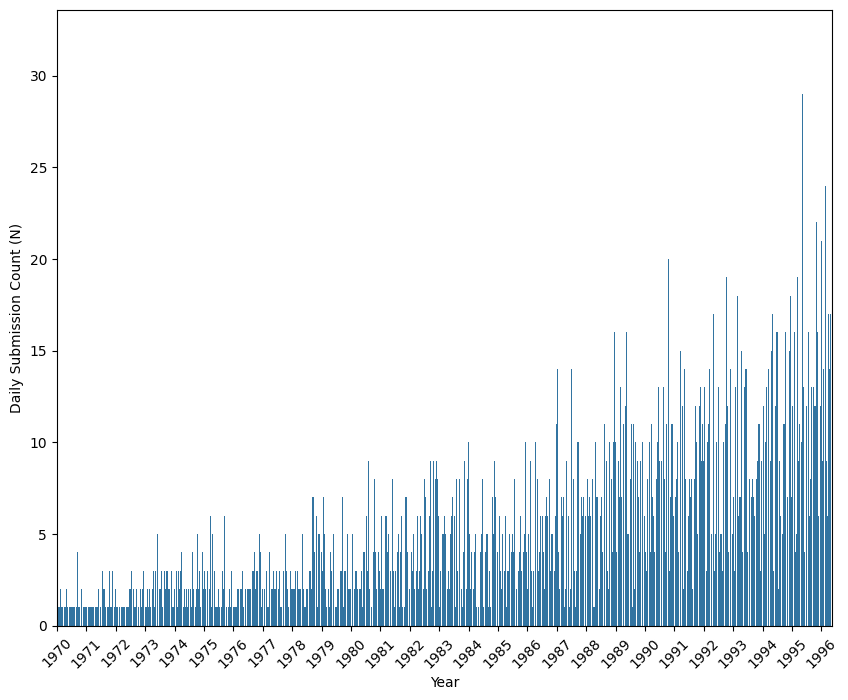

In [10]:
# Count abstracts submissions by date
count_by_date = data_raw.groupby("submission_dt").size().rename("n").to_frame()

# Initial plot
plt.figure(figsize=(10, 8))
sns.barplot(count_by_date, x = "submission_dt", y = "n")

# Tick only every year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Rotate labels to read
plt.xticks(rotation=45)

# Axis labels
plt.xlabel("Year")
plt.ylabel("Daily Submission Count (N)")
plt.show()

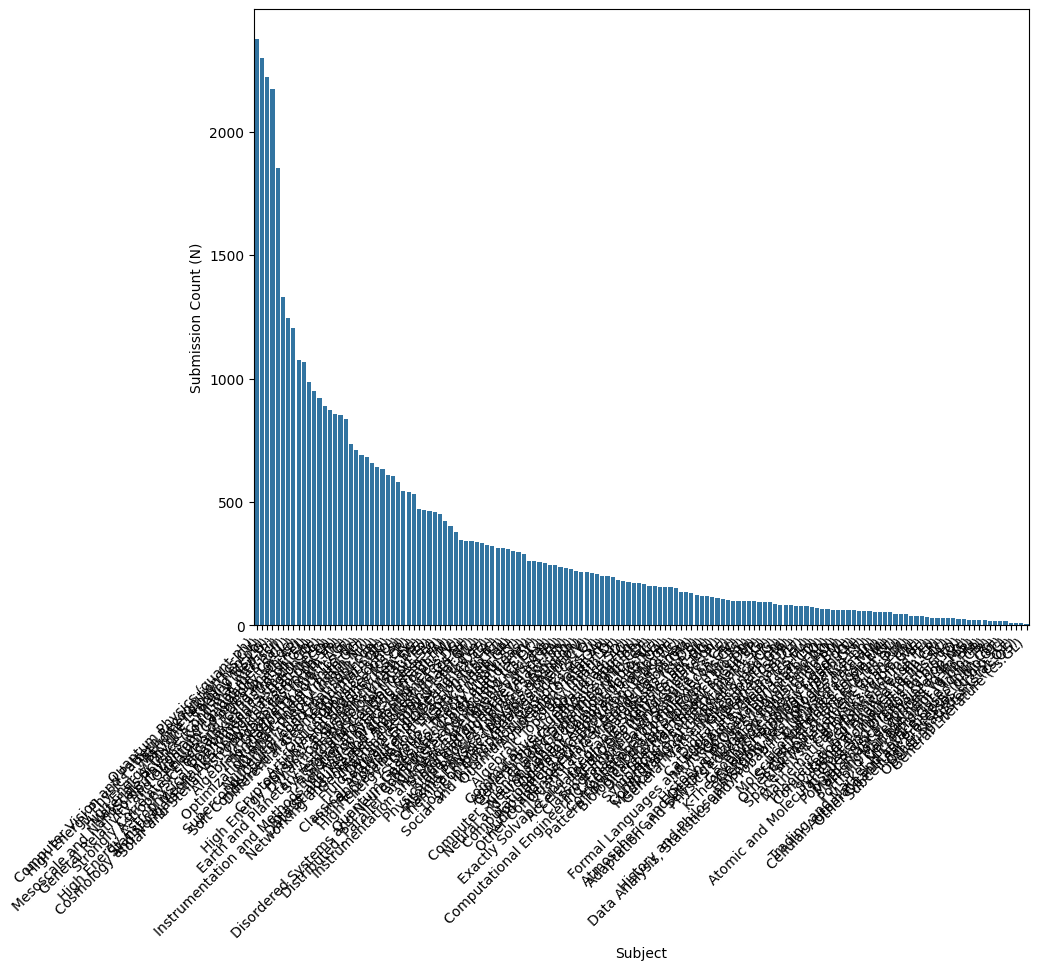

In [11]:
# Count abstracts by subject
count_by_subject = data_raw.groupby("primary_subject").size().rename("n").sort_values(ascending=False).to_frame()

plt.figure(figsize=(10, 8))
sns.barplot(count_by_subject, x = "primary_subject", y = "n")
plt.xlabel("Subject")
plt.ylabel("Submission Count (N)")
plt.xticks(rotation=45, ha='right')
plt.show()

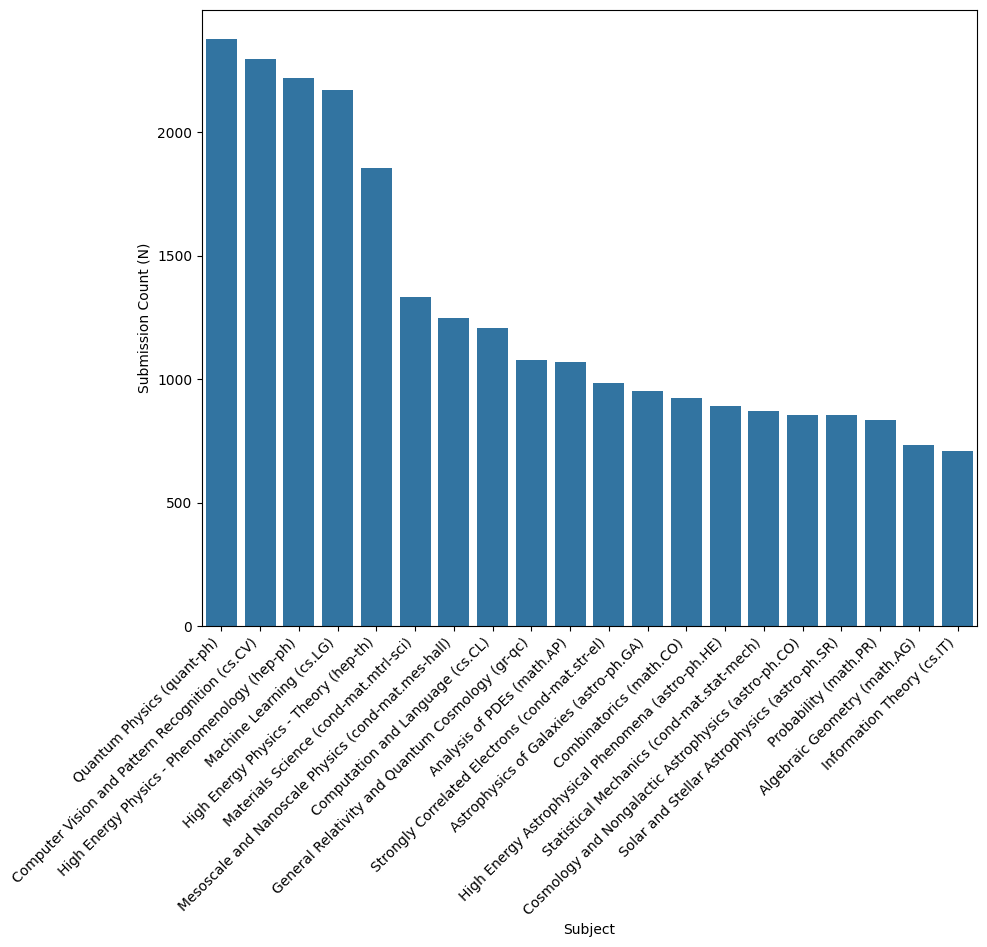

In [12]:
# Plot top twenty
plt.figure(figsize=(10, 8))
sns.barplot(count_by_subject.head(20), x = "primary_subject", y = "n")
plt.xlabel("Subject")
plt.ylabel("Submission Count (N)")
plt.xticks(rotation=45, ha='right')
plt.show()

### Abstract Characteristics

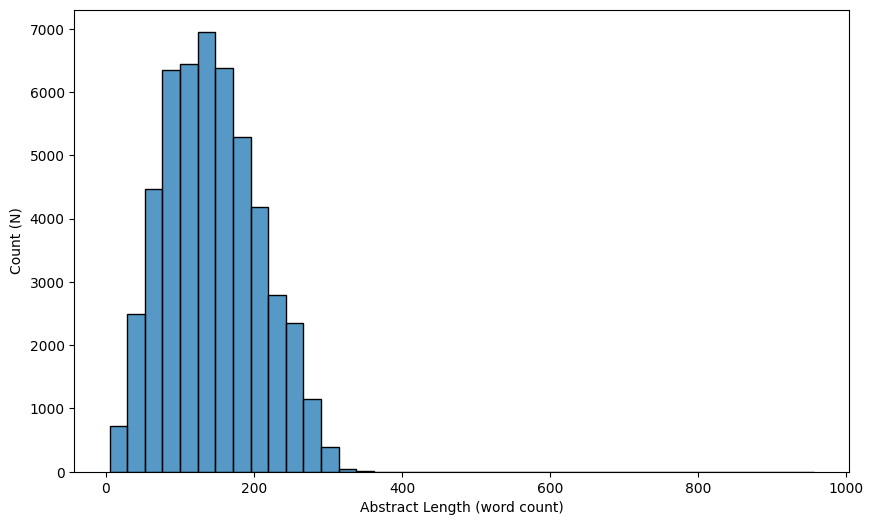

In [11]:
# Distribution of abstract length
data_raw["abstract_length"] = data_raw["abstract"].str.split().str.len()

plt.figure(figsize=(10,6))
sns.histplot(data_raw["abstract_length"], bins=40)
plt.xlabel("Abstract Length (word count)")
plt.ylabel("Count (N)")
plt.show()

In [12]:
# Median length year by year
data_raw["year"] = data_raw["submission_dt"].dt.year

median_by_year = (
    data_raw.groupby("year")["abstract_length"]
            .median()
            .reset_index(name="median_length")
)

median_by_year.head()

,year,median_length
0,1991,80.0
1,1992,85.5
2,1993,84.0
3,1994,89.5
4,1995,86.0


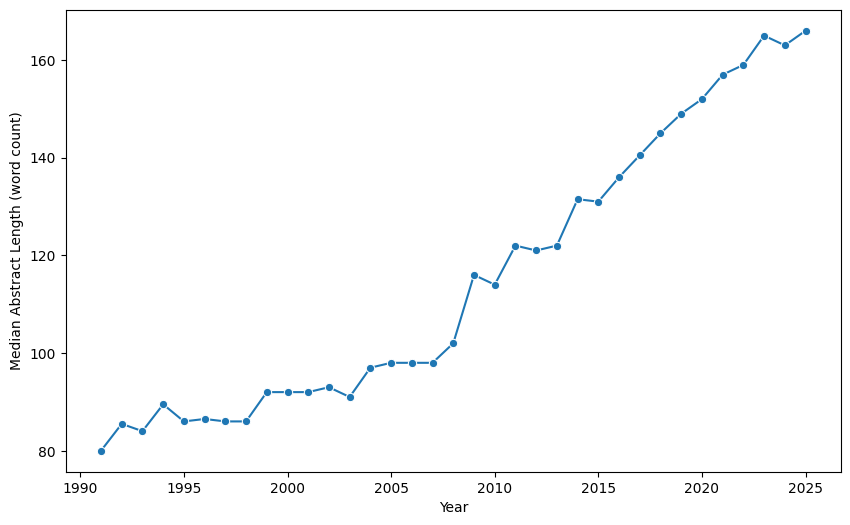

In [13]:
plt.figure(figsize = (10,6))
sns.lineplot(data = median_by_year, x = "year", y = "median_length", marker = "o")
plt.xlabel("Year")
plt.ylabel("Median Abstract Length (word count)")
plt.show()

In [14]:
# Length vs. Author Count
def count_authors(x):
    if isinstance(x, (list, np.ndarray)):
        return len(x)
    else:
        return 0

data_raw["n_authors"] = data_raw["authors"].apply(count_authors)
data_raw["n_authors"].head()

978205     8
373279     5
984330     1
2190293    8
1445403    4
Name: n_authors, dtype: int64

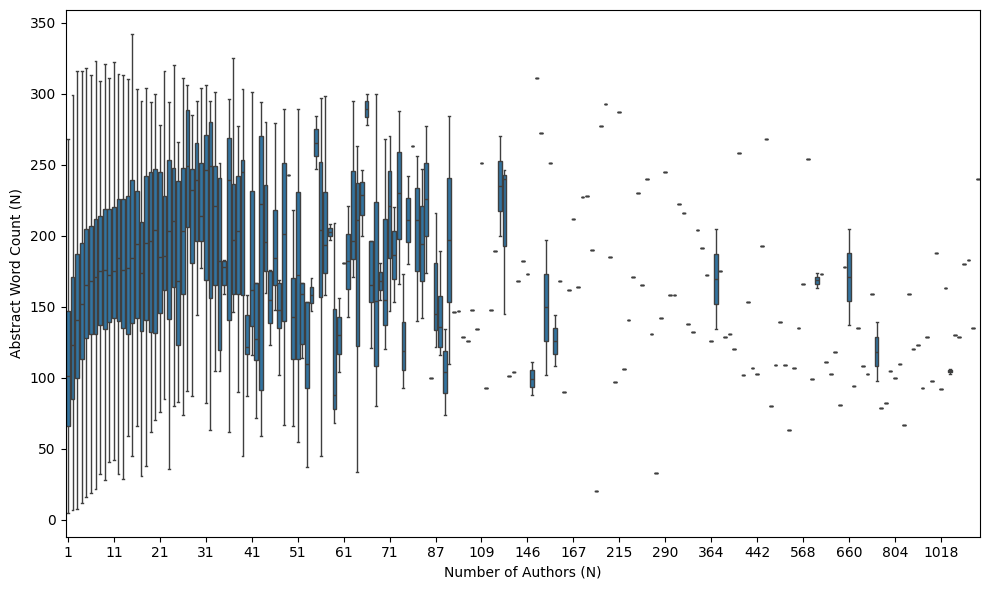

In [15]:
plt.figure(figsize = (10,6))
ax = sns.boxplot(data = data_raw, x = "n_authors", y = "abstract_length", showfliers = False)
ax.xaxis.set_major_locator(MultipleLocator(10))
plt.xlabel("Number of Authors (N)")
plt.ylabel("Abstract Word Count (N)")
plt.tight_layout()
plt.show()

### TF-IDF

In [16]:
# Text transformation via TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

texts = (
    data_raw["abstract"]
    .fillna("")
    .astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# Define TF-IDF transformer
tfidf = TfidfVectorizer(
    stop_words="english",     
    ngram_range=(1, 1),       
    min_df=5,                 
    max_df=0.6,               
    max_features=10000,
    strip_accents="unicode",
    lowercase=True
)

# Apply transformer
X = tfidf.fit_transform(texts)
vocab = np.array(tfidf.get_feature_names_out())

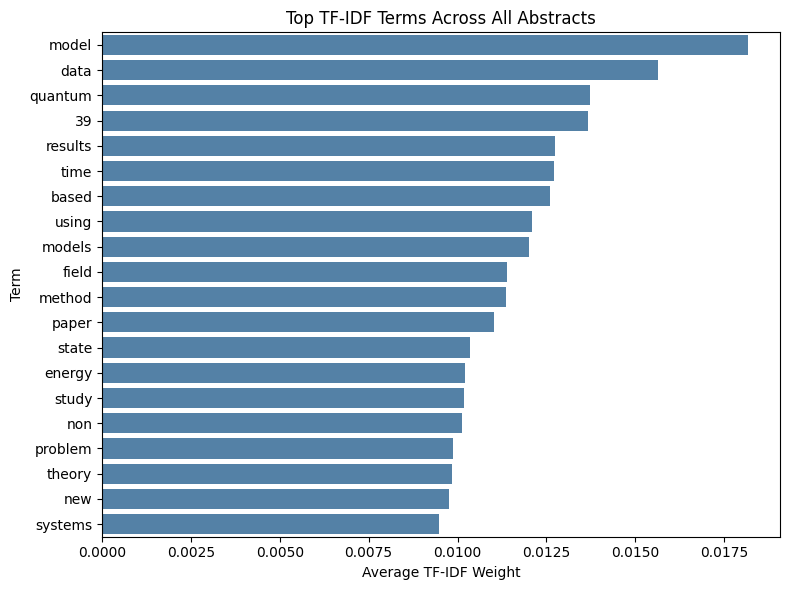

In [17]:
# Compute average TF-IDF per term
mean_tfidf = np.asarray(X.mean(axis=0)).ravel()

# Sort descending
top_idx = mean_tfidf.argsort()[::-1][:25]

# Get top terms and their TF-IDF value
top_terms = pd.DataFrame({
    "term": vocab[top_idx],
    "avg_tfidf": mean_tfidf[top_idx]
})

plt.figure(figsize=(8,6))
sns.barplot(data=top_terms.head(20), y="term", x="avg_tfidf", color="steelblue")
plt.title("Top TF-IDF Terms Across All Abstracts")
plt.xlabel("Average TF-IDF Weight")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

In [21]:
# Topic modeling (NMF)
from sklearn.decomposition import NMF

# Define number of topics
n_topics = 15

# Perform non-negative matrix factorization
nmf = NMF(n_components = n_topics, random_state = 42, init = "nndsvda", max_iter = 400) # Use NNDSVDA because sparsity is not desired.
W = nmf.fit_transform(X)  # (n_docs × n_topics)
H = nmf.components_       # (n_topics × n_terms)

# Get the tfidf vocabulary for downstream summary of topics
vocab = np.array(tfidf.get_feature_names_out())

In [22]:
# Inspect the derived topics and their terms
def show_topics(H, vocab, topn = 10):
    for i, weights in enumerate(H):
        top = weights.argsort()[::-1][:topn]
        terms = [vocab[j] for j in top]
        print(f"Topic #{i+1}: {', '.join(terms)}")

show_topics(H, vocab, topn = 10)

Topic #1: algorithm, problem, method, optimization, time, algorithms, optimal, proposed, problems, based
Topic #2: data, learning, analysis, privacy, training, machine, using, methods, sets, real
Topic #3: mathbb, mathcal, group, prove, algebra, finite, groups, algebras, space, 39
Topic #4: quantum, states, classical, entanglement, state, qubit, systems, information, qubits, photon
Topic #5: link, http, external, https, href, class, url, rel, nofollow, noopener
Topic #6: galaxies, star, mass, stars, ray, stellar, galaxy, emission, gas, 10
Topic #7: theory, gauge, field, black, theories, scalar, string, gravity, non, symmetry
Topic #8: phase, temperature, transition, energy, density, electron, states, state, surface, optical
Topic #9: quark, pi, gamma, mass, higgs, neutrino, production, energy, decay, gev
Topic #10: 34, 39, new, br, called, paper, social, classical, arxiv, known
Topic #11: solutions, equation, equations, solution, boundary, nonlinear, time, differential, existence, cond

In [23]:
# Add NMF topic to the dataframe
topic_idx = W.argmax(axis = 1)
data_raw["topic"] = topic_idx

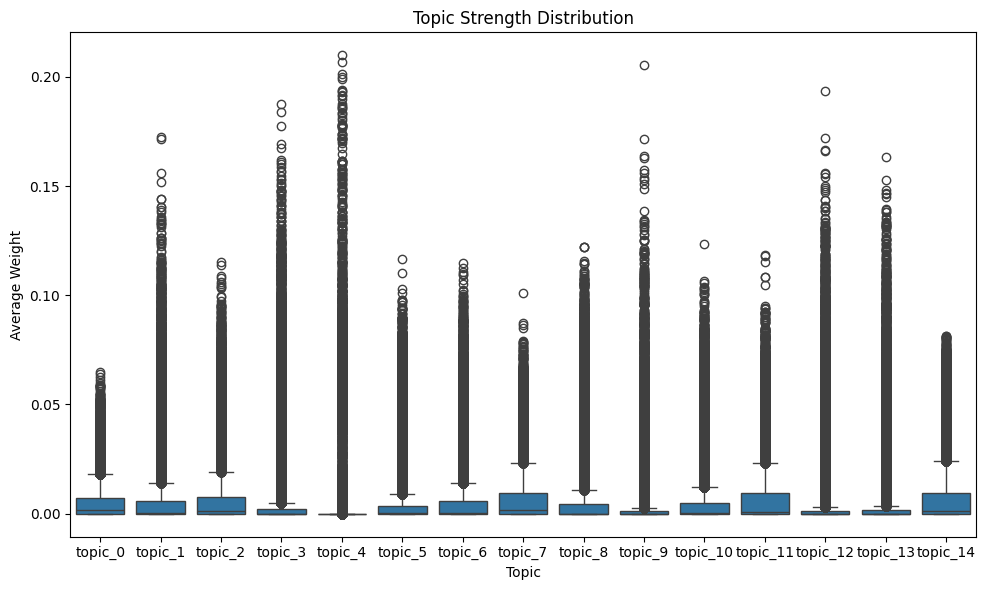

In [24]:
topic_strength = pd.DataFrame(W, columns=[f"topic_{i}" for i in range(n_topics)])
topic_strength["subject"] = data_raw["primary_subject"]

plt.figure(figsize=(10,6))
sns.boxplot(data=topic_strength.melt("subject"), x="variable", y="value")
plt.title("Topic Strength Distribution")
plt.xlabel("Topic")
plt.ylabel("Average Weight")
plt.tight_layout()
plt.show()

In [25]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 2, random_state = 42)
coords = svd.fit_transform(W)

plot_df = pd.DataFrame({
    "x": coords[:, 0],
    "y": coords[:, 1],
    "topic": data_raw["topic"].astype(str)
})

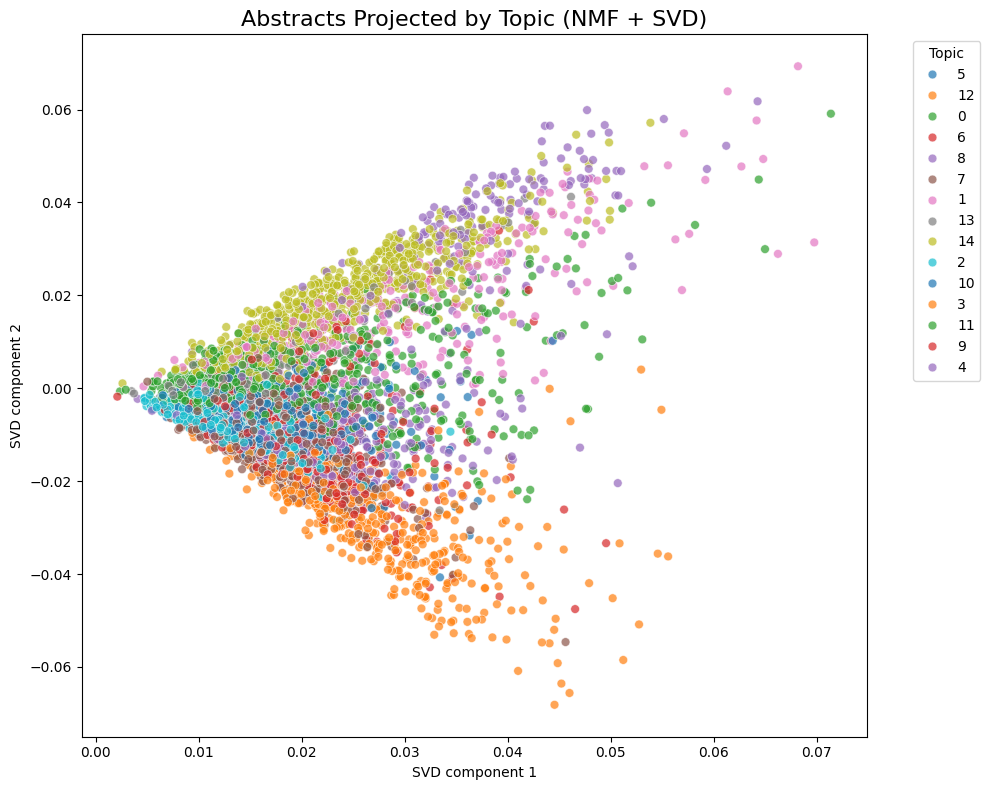

In [26]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data = plot_df.sample(min(len(plot_df), 5000), random_state = 42),
    x = "x", y = "y", hue = "topic", palette = "tab10", alpha = 0.7, s = 40
)

plt.title("Abstracts Projected by Topic (NMF + SVD)", fontsize=16)
plt.xlabel("SVD component 1")
plt.ylabel("SVD component 2")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [27]:
from umap import UMAP

umap_model = UMAP(
    n_neighbors=15,    # local neighborhood size
    min_dist=0.1,      # how tightly to pack points (lower = more cluster separation)
    metric='cosine',   # better for TF-IDF-like data
    random_state=42
)

coords_umap = umap_model.fit_transform(W)

plot_df = pd.DataFrame({
    "x": coords_umap[:, 0],
    "y": coords_umap[:, 1],
    "topic": data_raw["topic"].astype(str),
    "primary_subject": data_raw["primary_subject"].astype(str),
    "abstract_length": data_raw["abstract_length"].astype(str),
})

/Users/m092364/Documents/projects/nlp/arxiv_abstracts/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


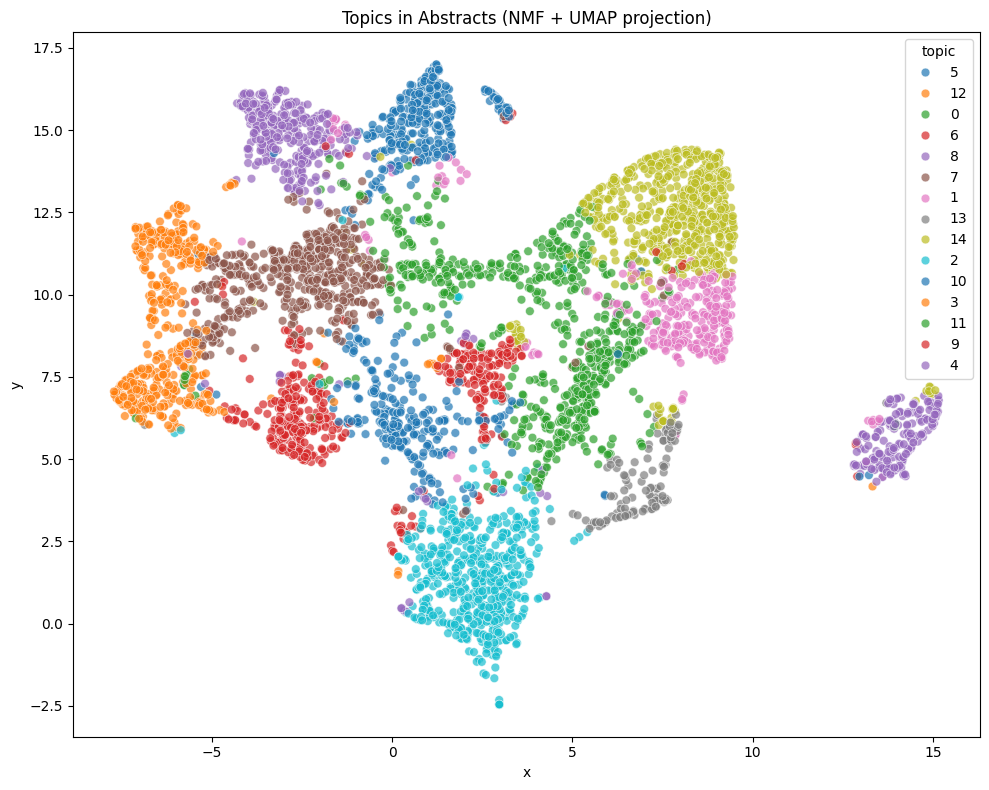

In [28]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=plot_df.sample(min(len(plot_df), 5000), random_state=42),
    x="x", y="y", hue="topic", palette="tab10", s=40, alpha=0.7
)
plt.title("Topics in Abstracts (NMF + UMAP projection)")
plt.tight_layout()
plt.show()

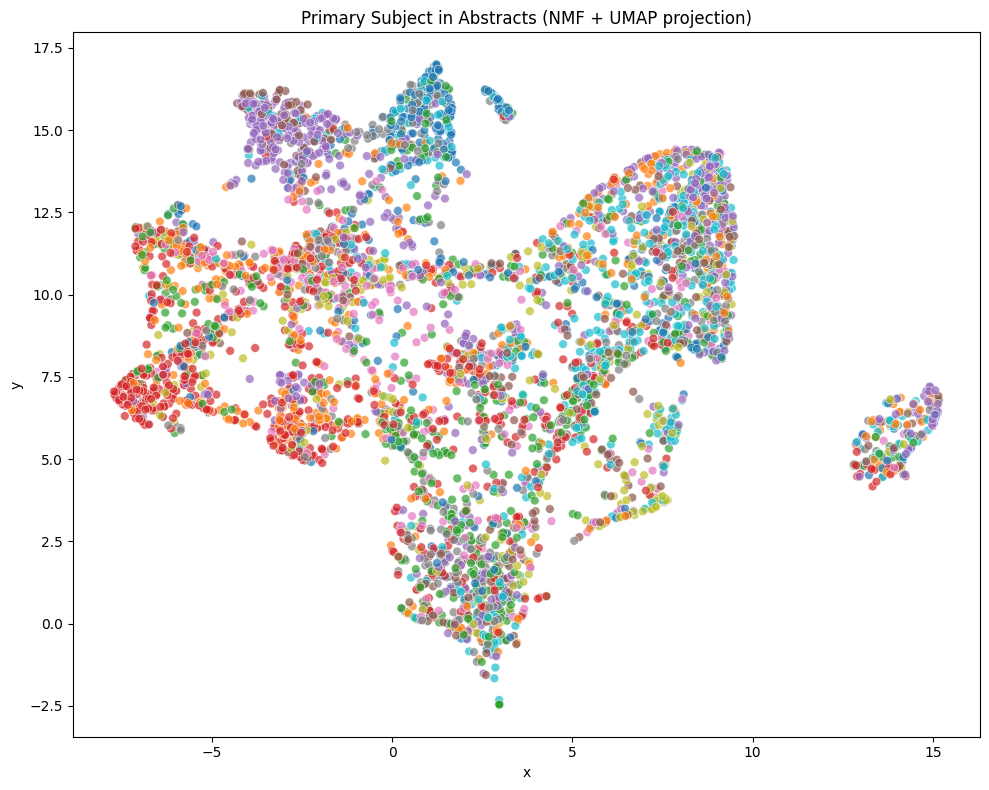

In [28]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=plot_df.sample(min(len(plot_df), 5000), random_state=42),
    x="x", y="y", hue="primary_subject", palette="tab10", s=40, alpha=0.7,
    legend=False
)
plt.title("Primary Subject in Abstracts (NMF + UMAP projection)")
plt.tight_layout()
plt.show()

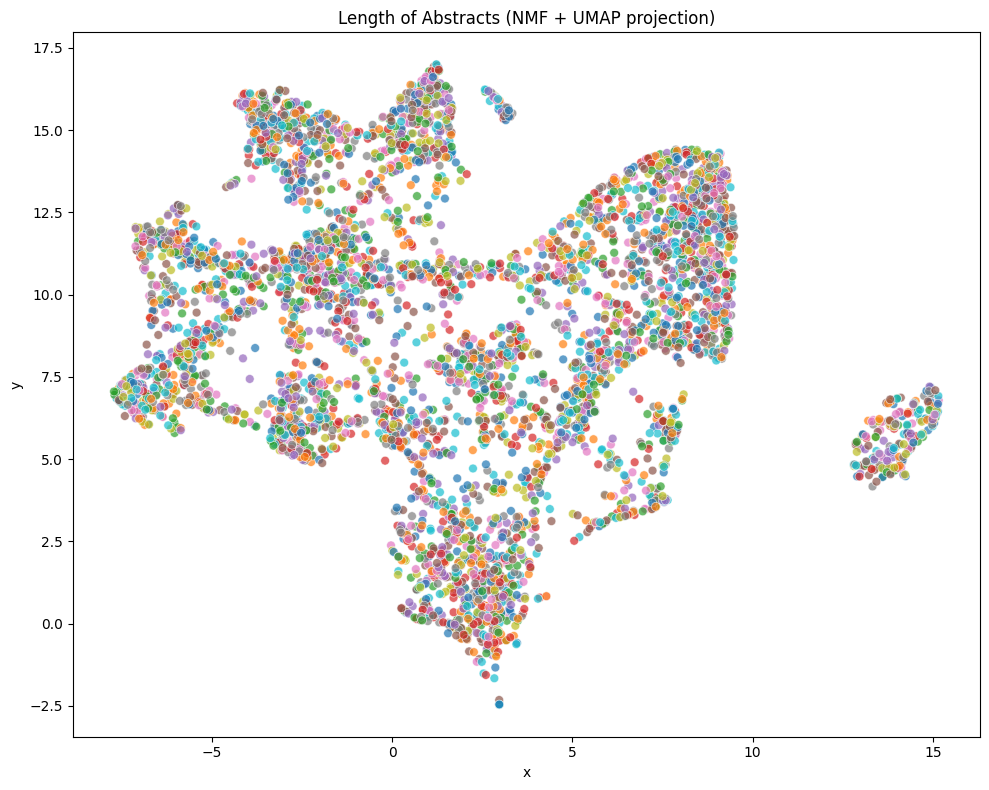

In [29]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=plot_df.sample(min(len(plot_df), 5000), random_state=42),
    x="x", y="y", hue="abstract_length", palette="tab10", s=40, alpha=0.7,
    legend=False
)
plt.title("Length of Abstracts (NMF + UMAP projection)")
plt.tight_layout()
plt.show()

## Title Content

In [30]:
titles = (
    data_raw["title"]
    .fillna("")
    .astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# Define TF-IDF transformer
tfidf_titles = TfidfVectorizer(
    stop_words="english",     
    ngram_range=(1, 1),       
    min_df=5,                 
    max_df=0.6,               
    max_features=10000,
    strip_accents="unicode",
    lowercase=True
)

# Apply transformer
X_titles = tfidf_titles.fit_transform(titles)
vocab_titles = np.array(tfidf_titles.get_feature_names_out())

In [31]:
# Define number of topics
n_topics = 15

# Perform non-negative matrix factorization
nmf_titles = NMF(n_components = n_topics, random_state = 42, init = "nndsvda", max_iter = 400) # Use NNDSVDA because sparsity is not desired.
W_titles = nmf_titles.fit_transform(X_titles)  # (n_docs × n_topics)
H_titles = nmf_titles.components_       # (n_topics × n_terms)y6

# Get the tfidf vocabulary for downstream summary of topics
vocab_titles = np.array(tfidf_titles.get_feature_names_out())

In [32]:
# Inspect the derived topics and their terms
show_topics(H_titles, vocab_titles, topn = 10)

Topic #1: non, time, equations, linear, solutions, groups, space, equation, finite, functions
Topic #2: quantum, mechanics, classical, entanglement, state, states, gravity, hall, dots, dot
Topic #3: learning, deep, reinforcement, machine, multi, supervised, federated, representation, self, contrastive
Topic #4: models, language, large, scale, vision, diffusion, knowledge, generation, generative, pre
Topic #5: networks, neural, network, graph, convolutional, deep, wireless, recurrent, training, complex
Topic #6: model, standard, quark, higgs, hubbard, language, ising, lattice, diffusion, selection
Topic #7: theory, field, string, gauge, effective, perturbation, mills, yang, conformal, gravity
Topic #8: 39, theorem, conjecture, 34, problem, proof, function, comment, green, law
Topic #9: based, multi, image, detection, network, approach, method, optimization, video, design
Topic #10: using, detection, estimation, method, images, network, segmentation, 3d, generation, object
Topic #11: spi

In [33]:
umap_model_titles = UMAP(
    n_neighbors=15,    # local neighborhood size
    min_dist=0.1,      # how tightly to pack points (lower = more cluster separation)
    metric='cosine',   # better for TF-IDF-like data
    random_state=42
)

coords_umap_titles = umap_model_titles.fit_transform(W_titles)

plot_df = pd.DataFrame({
    "x": coords_umap[:, 0],
    "y": coords_umap[:, 1],
    "topic_title": data_raw["topic"].astype(str),
    "primary_subject": data_raw["primary_subject"].astype(str),
    "abstract_length": data_raw["abstract_length"].astype(str),
})

/Users/m092364/Documents/projects/nlp/arxiv_abstracts/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


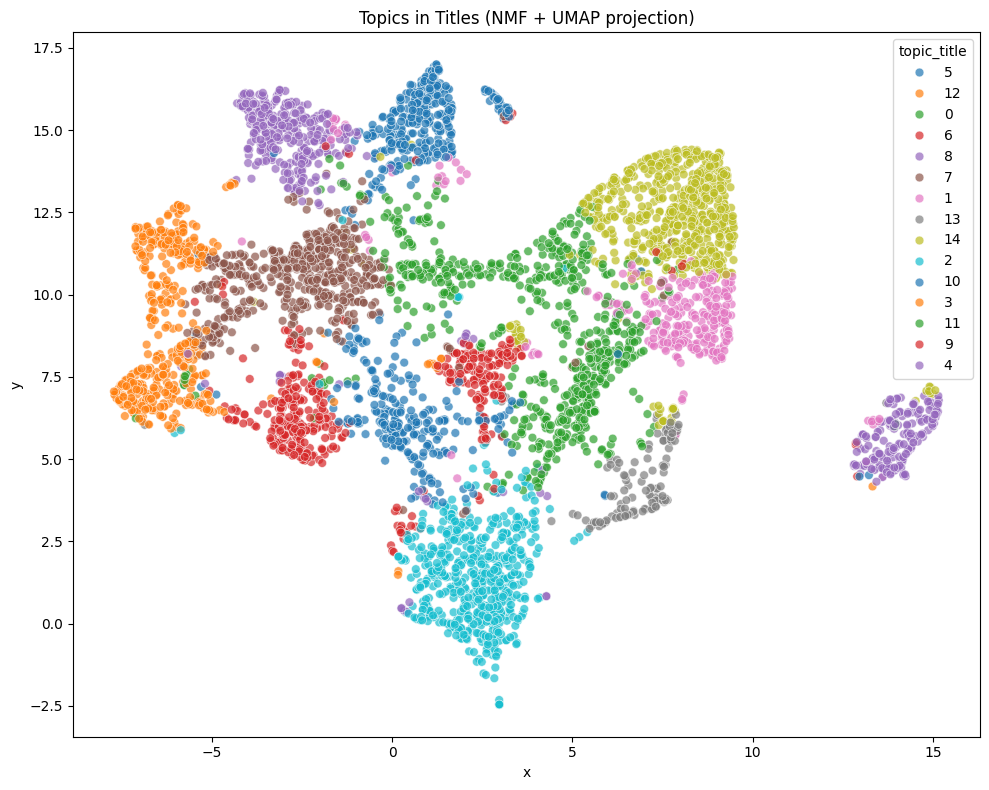

In [36]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=plot_df.sample(min(len(plot_df), 5000), random_state=42),
    x="x", y="y", hue="topic_title", palette="tab10", s=40, alpha=0.7
)
plt.title("Topics in Titles (NMF + UMAP projection)")
plt.tight_layout()
plt.show()